## Aritmética de punto flotante

Link a conversor __[IEEE 754 precisión simple](https://www.h-schmidt.net/FloatConverter/IEEE754.html)__

_El objetivo de este notebook es acercar a la práctica lo visto en las diapositivas del laboratorio, e ir calentando las aguas para los desafíos que vendran. Usenla en combinación con las diapositivas._

Representacion:

    (-1)^s * (1+f) 2^{e-127}

    - (1+f) es la mantissa y esta entre 0 y 1.
    - 127 cambia segun si es representacion simple o doble.

## Una inocente suma

Si hacemos 0.2 + 0.3 en la computadora, esperamos encontrar 0.5 como resultado, ¿pero qué está pasando realmente de fondo? Exploremos más esta operación.

In [1]:
0.25 + 0.3 # El resultado es acorde a lo esperado

0.55

In [2]:
x = 0.3 # Si pedimos que se imprima el valor no se observa nada raro.
print(x)

0.3


Sin embargo, si calculamos la diferencia entre ambos (que debería da 0.1), algo "inesperado" ocurre:

In [ ]:
0.3 - 0.25 # El resultado es CASI 0.05

0.04999999999999999

Recuerdo:

$$(x)_b = sign 2^{\text{exponent}} \text{mantissa}$$

En precisión simple, la mantisa tiene 23 bits y el exponente 8.

$$x = (-1)^{b_{31}} \times (1 + \sum_{i=0}^{22} b_{22-i} 2^{-i}) \times 2^{e-127}$$

_Para pensar_: 
- Escriba el número 0.25 en base 2. ¿Cómo queda expresado en términos de su mantisa y exponente?

              S | Exponente | Mantissa 
    (0.25)b = 0 | 01111101  | 00000000000000000000000
            = 2⁻2

- Escriba el número 0.3 en base 2. ¿Qué dificultades aparecen al escribir 0.3 en binario? ¿Se puede escribir exactamente con una mantisa finita?}

              S | Exponente | Mantissa
    (0.3)b  = 0 | 01111101  | 00110011001100110011010

Otro ejemplo:

- ¿Cuánto da $(\sqrt{2})^2 - 2$? Simbólicamente sabemos que el resultado es 0, pero...


In [4]:
import numpy as np
np.sqrt(2)**2-2 

4.440892098500626e-16

_Para pensar_: ¿cuántos errores de redondeo se comenten al realizar la operación anterior? ¿Qué operaciones generan el error?

- Como hay 3 operaciones y todas las operaciones tienen error ($\sqrt, +, -$) $\rightarrow$ se genera la diferencia.

Un ejemplo más:

- ¿Cuál es el límite cuando $n \rightarrow \infty$ de esta sucesión?
$$
\begin{aligned}
x_1 &= \sqrt{2} \\
x_{n+1} &= \frac{x_n \cdot x_n}{\sqrt{2}}
\end{aligned}
$$

> Intento: 
>>  $\lim_{n \rightarrow \inf} x_{n+1} = \frac{x_n \cdot x_n}{\sqrt{2}} =^{L'H} \frac{2 x_n}{1} \rightarrow \inf$

Algebráicamente podemos calcular:

$x_1 = \sqrt{2}$, $x_2 = \frac{x_1 \cdot x_1}{\sqrt{2}} = \frac{2}{\sqrt{2}} = \sqrt{2} = x_1$,

con lo cual podemos concluir que la serie converge en el primer paso, ya que necesariamente será $x_3=x_2=x_1$, etc.

Si lo calculamos con la máquina:

In [5]:
x = np.sqrt(2)
print(x)
l = [x]
for i in range(100):
    x = (x * x) / np.sqrt(2)
    l.append(x)
print(x)

1.4142135623730951
inf


/tmp/ipykernel_90537/4215209067.py:5: RuntimeWarning: overflow encountered in scalar multiply
  x = (x * x) / np.sqrt(2)


Text(0, 0.5, 'Elemento de la sucesión, $x_i$')

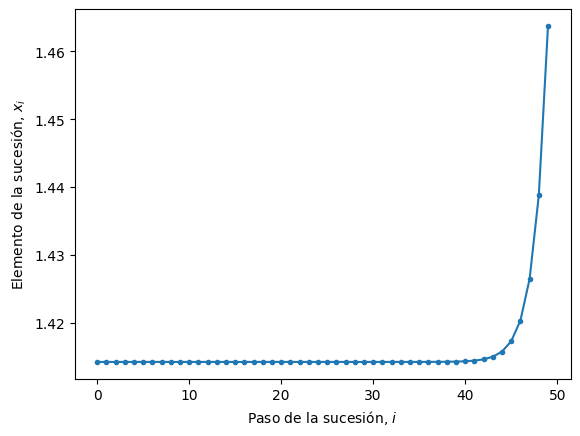

In [6]:
# Si visualizamos la sucesión:
import matplotlib.pyplot as plt
plt.plot(l[:50],marker='.') # Visualizamos los primeros 50 para poder observar el comportamiento
plt.xlabel('Paso de la sucesión, $i$')
plt.ylabel('Elemento de la sucesión, $x_i$')

Pueden ver como desde el paso $40$ el error empieza volverse visible y se dispara muy rápidamente.

In [29]:
np.sqrt(2)/100000 # Preguntar para qué está

1.4142135623730951e-05

In [30]:
10.0**(-3) # Preguntar para qué está

0.001

## Acumulación de errores

1. Se quiere calcular 
$$
\sum_{i=1}^{10^n} \frac{1}{i} \quad y \quad \sum_{i=1}^{5\cdot10^n} \frac{1}{i} 
$$ 
usando aritmética de simple precisión (`float32`). Ejecutar los siguientes programas e interpretar los resultados, observando en particular el resultado para $n=6$ y $n=7$. ¿Qué está ocurriendo?

In [33]:
import numpy as np

n = 6
s = np.float32(0)
for i in range(1,10**n+1):
    s = s + np.float32(1/i)
print("suma = ", s)

s = np.float32(0)
for i in range(1,5*10**n+1):
    s = s + np.float32(1/i)
print("suma = ", s)

# Resultado: 
# Para n=6 dan distinto y con n=7 dan igual

suma =  14.357358
suma =  15.403683


_Algunas preguntas guía_:
1. ¿Cuánto vale $1/i$ en precisión simple cuando $i=2\cdot 10^7$?

- $\frac{1}{2 \cdot 10^7} = 2^{-1} * 10^{-7}$
- O sea, x = 0 | 10000000 | (10^{-7})b 


2. Si escribimos $1/10^7$ usando el mismo exponente que el necesario para representar a $\sum^{5\cdot 10^6}_{i=1} 1/i$, ¿a cuánto equivale $1/i$?

- ¿Qué modificación podría hacerse para reducir los errores numéricos?

In [34]:
# Si invertimos el orden de la sumatoria, el nuevo sumando tiene un orden similar al de la sumatoria previa
s = np.float32(0)
for i in range(2*10**n,0,-1):
    s = s + np.float32(1/i)
print("suma = ", s)

suma =  15.086579


2. Utilizar las mismas estrategias para estimar $e$ mediante la serie
$$
e \approx \sum_{n=0}^{10} \frac{1}{n!}.
$$

Comparar el resultado de cada estrategia con el valor real con el valor real (recordar que existe `np.e`).

Obs: sumar cosas parecidas es mejor que sumar cosas diferentes.

In [49]:
fact = lambda n: 1 if n <= 1 else n * fact(n-1)

e_ = np.float32(0)
for m in range(10, -1, -1):
    e_ += np.float32(1/fact(m))

print(e_)
print(f"diferencia: {np.e - e_}")

2.7182817
diferencia: 8.25484005595456e-08


3. El siguiente código suma 1 $10^8$ veces. ¿Coincide la respuesta con el valor esperado? ¿Es posible modificar el código para calcular el valor correcto?

In [11]:
c = np.float32(0.0)
for i in range(10**8):
    c += np.float32(1)
print(c)

16777216.0


In [ ]:
c = np.float32(0.0)
for i in range(10**8, 0, -1):
    c += np.float32(1)
print(c)

16777216.0


# Características del `float64`

In [52]:
# Máximo número flotante que puede representar Python:
print('Máximo número flotante que puede representar Python: ', np.finfo(float).max, '\n')

# Mínimo flotante positivo normalizado que puede representar Python:
print('Mínimo flotante positivo [normalizado] que puede representar Python: ', np.finfo(float).tiny, '\n')

# Mínimo flotante positivo [subnormal] que puede representar Python:
print('Mínimo flotante positivo [subnormal] que puede representar Python: ', np.nextafter(0., 1.), '\n')

# Epsilon de máquina
print('Epsilon de máquina: ', np.finfo(float).eps)

Máximo número flotante que puede representar Python:  1.7976931348623157e+308 

Mínimo flotante positivo [normalizado] que puede representar Python:  2.2250738585072014e-308 

Mínimo flotante positivo [subnormal] que puede representar Python:  5e-324 

Epsilon de máquina:  2.220446049250313e-16


In [13]:
# Veamos que efectivamente el épsilon de máquina es el número de máquina más chico tal que 1 + eps es distinto de 1

eps = np.finfo(np.double).eps
print('1 + ε =', 1 + eps)
print('1 + ε/2 =', 1 + eps/2,'\n')

print('¿1 + ε = 1?', 1 + eps == 1)
print('¿1 + ε/2 = 1?', 1 + eps/2 == 1)

1 + ε = 1.0000000000000002
1 + ε/2 = 1.0 

¿1 + ε = 1? False
¿1 + ε/2 = 1? True


## Volviendo al 0.1

Vamos a explorar un poco más en detalle cómo representa la máquina al inocente 0.1, y de paso familiarizarnos con algunas funciones de `numpy` más.

In [14]:
print(0.1)
print(f"{np.single(0.1):.17f}") # muestro 17 lugares después de la coma
# format(0.1,'.17f') # hace lo mimso que lo de arriba

0.1
0.10000000149011612


In [15]:
# Si lo representamos con mayor número de decimales, vemos que 0.3 y 0.1+0.2 no son lo mismo
print(f"0.1 + 0.2 = {0.1:.17f} + {0.2:.17f} = {0.1+0.2:.17f}") 
print(f"0.3 = {0.3:.17f}")

0.1 + 0.2 = 0.10000000000000001 + 0.20000000000000001 = 0.30000000000000004
0.3 = 0.29999999999999999


¿Qué entiende la máquina por 0.1?

In [59]:
# Esto devuelve la mantissa como un valor entre -1 y 1 y el exponente del 2 (formato amigable)
mantissa, exponent = np.frexp(np.single(0.1))
(mantissa, exponent)

(0.8, -3)

In [57]:
print(2**(-3)*0.8)

0.1


In [60]:
# Chequeo
mantissa, exp = np.frexp(np.single(0.1))
mantissa * 2.**exp

0.10000000149011612

Si les hace ruido que el $0.8$ no está en binario, ¡bien! Lo que pasa es que, en realidad, el 0,8 es 0,[tira de 24 1s y 0s]. Si pedimos que lo represente explicitamente:

In [18]:
mantissa_maquina = mantissa*(2**24) # corro la coma 24 lugares 

print('Mantissa guardada:')
f"{int(mantissa_maquina):b}" # muestro en binario


Mantissa guardada:


'110011001100110011001101'

Aunque en verdad, verdad, no guarda $0,8 . 2^{-3}$ si no $1,6 . 2^{-4}$,

donde el $1$ se asume y lo que se guarda es el $0,6$ en binario con 23 dígitos.

O sea que el primer 1 de arriba no se guarda

In [19]:
print('Mantissa guardada de verdad:')
f"{int(mantissa_maquina):b}"[1:] # muestro en binario

Mantissa guardada de verdad:


'10011001100110011001101'

# Jugando con `float16`

`np.float16` es una versión de punto flotante de 16 bits. 

Se usa 1 bit para el signo, 5 para el exponente y 10 para la mantissa (que recordando el truco del 1 que vimos para `float64`,  puedo emplear 11 digitos signficativos)

In [20]:
# Máximo número flotante que puede representar en float16:
print('Máximo número flotante que puede representar en float16: ', np.finfo(np.float16).max, '\n')

# Mínimo flotante positivo normalizado que puede representar en float16:
print('Mínimo flotante positivo [normalizado] que puede representar en float16: ', np.finfo(np.float16).tiny, '\n')

# Mínimo flotante positivo [subnormal] que puede representar en float16:
print('Mínimo flotante positivo [subnormal] que puede representar en float16: ', np.nextafter(np.float16(0.), np.float16(1.)), '\n')

# Epsilon de máquina
print('Epsilon de máquina: ', np.finfo(np.float16).eps)

Máximo número flotante que puede representar en float16:  65500.0 

Mínimo flotante positivo [normalizado] que puede representar en float16:  6.104e-05 

Mínimo flotante positivo [subnormal] que puede representar en float16:  6e-08 

Epsilon de máquina:  0.000977


Fijense que la precisión es del orden de 0.001. Así que es parecido a trabajar con base 10 y mantissa de 3 digitos

In [21]:
np.nextafter(np.float16(1),np.float16(2))

1.001

A partir de $2^{10} = 1024$ y hasta $2^{11} = 2048$ los números que puedo representar son los enteros

In [22]:
print("El siguiente a 1024 es: ")
np.nextafter(np.float16(1024),np.float16(2000))

El siguiente a 1024 es: 


1025.0

A partir de $2^{11} = 2048$ ya sólo tengo números pares

In [23]:
print("El siguiente a 2048 es: ")
np.nextafter(np.float16(2048),np.float16(2050))

El siguiente a 2048 es: 


2050.0

### Algunos problemas con la representación de 16 bits


In [24]:
# Problema 1: sumar dos números muy distintos en magnitud hace que el más chico sea ignorado
x = np.float16(2048)
y = np.float16(1)
print(f'{x} + {y} = {x + y}')
print(x + y == x)

2048.0 + 1.0 = 2048.0
True


In [25]:
# Problema 1': lo mismo puede pasar si sumamos muchos números chicos
# Acá hago 1 + 1 + 1 + ... 3000 veces
s =  np.float16(0)
for i in range(3000):
    s += np.float16(1)
s

2048.0

In [26]:
# Problema 1'': también si sumamos cosas cada vez más chiquitas

# Hago un doble for para calcular las sumas parciales de 1/n hasta distintos valores
for n in range(200,1001,200):
    s =  np.float16(0)
    for i in range(1,n):
        s += np.float16(1/i)
    print(f'Suma de los primeros {n} terminos de 1/n : {s}')
f'Conclusión: la serie armonica converge a {s} :('

Suma de los primeros 200 terminos de 1/n : 5.86328125
Suma de los primeros 400 terminos de 1/n : 6.64453125
Suma de los primeros 600 terminos de 1/n : 7.0859375
Suma de los primeros 800 terminos de 1/n : 7.0859375
Suma de los primeros 1000 terminos de 1/n : 7.0859375


'Conclusión: la serie armonica converge a 7.0859375 :('

In [27]:
# Problema 2: restar dos números muy parecidos genera cancelaciones catastróficas 
x = 256.22
y = 256.02
flx = np.float16(x)
fly = np.float16(y)

print(f'Cuenta bien: {x} - {y} = {x - y:.2f}')
print(f'En float16: {flx} - {fly} = {flx - fly}')

error = np.float16(abs((x-y)-(flx-fly)))
print('Errror = ',error)
print(f'Error relativo = {error:.2f}/{(x-y):.2f} = {error/(x-y):.0%}')

Cuenta bien: 256.22 - 256.02 = 0.20
En float16: 256.25 - 256.0 = 0.25
Errror =  0.05
Error relativo = 0.05/0.20 = 25%
